In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset,DataLoader
import matplotlib.pyplot as plt

In [3]:
torch.manual_seed(42)   # set for reproducibility

In [4]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [5]:
df= pd.read_csv("fashion-mnist_train.csv")
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


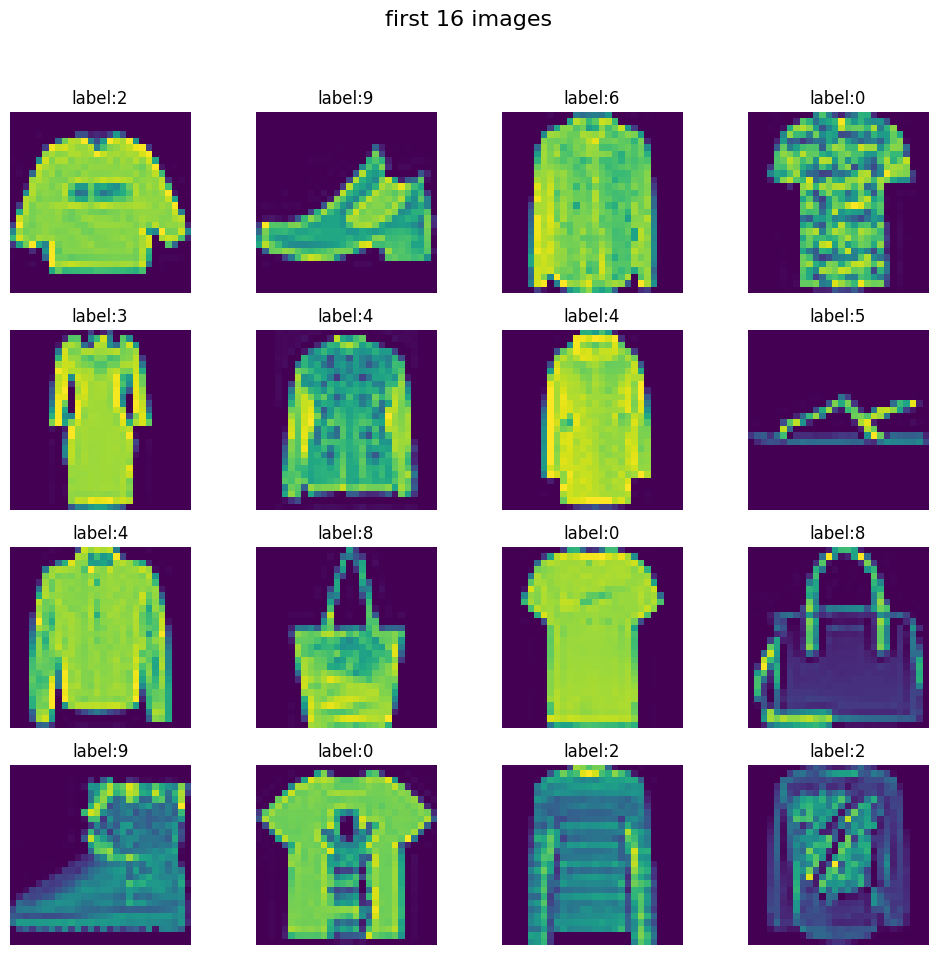

In [6]:
# create a 4x4 grid images

fig,axes=plt.subplots(4,4,figsize=(10,10))
fig.suptitle("first 16 images",fontsize=16)

# plot the first 16 images from the dataset

for i,ax in enumerate(axes.flat):
    ax.imshow(df.iloc[i,1:].values.reshape(28,28))
    ax.axis("off")
    ax.set_title(f"label:{df.iloc[i,0]}")

plt.tight_layout(rect=[0,0.03,1,0.95])
plt.show()

In [7]:
# train test split
x=df.iloc[:,1:].values
y=df.iloc[:,0].values

x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)

In [8]:
# scaling the features
x_train=x_train/255.0
x_test=x_test/255.0

In [9]:
x_train

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.00392157, 0.        ,
        0.        ]])

In [10]:
# create customdataset

class CustomDataset(Dataset):
  def __init__(self,features,labels):
    self.features=torch.tensor(features,dtype=torch.float32)
    self.labels=torch.tensor(labels,dtype=torch.long)

  def __len__(self):
    return len(self.features)

  def __getitem__(self,index):
    return self.features[index],self.labels[index]




In [11]:
train_dataset=CustomDataset(x_train,y_train)

In [ ]:
len(train_dataset)
train_dataset[0]

In [13]:
test_dataset=CustomDataset(x_test,y_test)

In [14]:
train_loader=DataLoader(train_dataset,batch_size=32,shuffle=True,pin_memory=True)
test_loader=DataLoader(test_dataset,batch_size=32,shuffle=False,pin_memory=True)


In [42]:
class MYnn(nn.Module):
  def __init__(self,input_dim,output_dim,num_hidden_layers,neurons_per_layer,dropout_rate):
    super().__init__()
    layers=[]
    for i in range(num_hidden_layers):
      layers.append(nn.Linear(input_dim,neurons_per_layer))
      layers.append(nn.BatchNorm1d(neurons_per_layer))
      layers.append(nn.ReLU())
      layers.append(nn.Dropout(dropout_rate))
      input_dim=neurons_per_layer

    layers.append(nn.Linear(neurons_per_layer,output_dim))
    self.model=nn.Sequential(*layers)

  def forward(self,x):
     return self.model(x)


In [43]:
# objective function
def objective(trial):

  # next hyperparameter values from the search space
  num_hidden_layers = trial.suggest_int("num_hidden_layers", 1, 5)
  neurons_per_layer = trial.suggest_int("neurons_per_layer", 8, 128, step=8)
  epochs = trial.suggest_int("epochs", 10, 50, step=10)
  learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)
  dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5, step=0.1)
  batch_size = trial.suggest_categorical("batch_size", [16, 32, 64, 128])
  optimizer_name = trial.suggest_categorical("optimizer", ['Adam', 'SGD', 'RMSprop'])
  weight_decay = trial.suggest_float("weight_decay", 1e-5, 1e-3, log=True)

  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
  test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

  # model init
  input_dim = 784
  output_dim = 10

  model = MYnn(input_dim, output_dim, num_hidden_layers, neurons_per_layer, dropout_rate)
  model.to(device)

  # optimizer selection
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model.parameters(), lr=0.1, weight_decay=1e-4)

  if optimizer_name == 'Adam':
    optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
  elif optimizer_name == 'SGD':
    optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
  else:
    optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

  # training loop

  for epoch in range(epochs):

    for batch_features, batch_labels in train_loader:

      # move data to gpu
      batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

      # forward pass
      outputs = model(batch_features)

      # calculate loss
      loss = criterion(outputs, batch_labels)

      # back pass
      optimizer.zero_grad()
      loss.backward()

      # update grads
      optimizer.step()


  # evaluation
  model.eval()
  # evaluation on test data
  total = 0
  correct = 0

  with torch.no_grad():

    for batch_features, batch_labels in test_loader:

      # move data to gpu
      batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

      outputs = model(batch_features)

      _, predicted = torch.max(outputs, 1)

      total = total + batch_labels.shape[0]

      correct = correct + (predicted == batch_labels).sum().item()

    accuracy = correct/total

  return accuracy

In [ ]:
!pip install optuna

In [34]:
import optuna
study=optuna.create_study(direction="maximize")

[I 2026-01-02 10:10:23,407] A new study created in memory with name: no-name-6cb64c8b-19ab-48b2-814f-82c5d806c9f9


In [ ]:
study.optimize(objective,n_trials=10)